# Predicting AFL winners using Machine Learning - Predictions

---

<img src='img/dartboard.jpg'>

---

Using the data and features created in the previous section **[Section 1 - Feature Preprocessing](Section 1 - Feature Preprocessing.ipynb)**. We are now going to try and use the data to form some predictions regarding the probability of the home the home team winning. 

In the Notebook below, we will start with a Naive model which only uses the previous year's ladder scores as a predictor and winning team's location as the target. From there we will add:

* Information regarding the teams, in the form of dummified team names
* Head to Head data from the previous 5 times the two teams have played
* Previous game's statistics

These models will be tested under several classification techniques including Logistic Regression, Support Vector Machines (SVM), Random Forest and Gradient Boosting.

Following that, we will subject these classifiers to a gridsearch to maximize their accuracy and F1-scores.

I have specifically opted to avoid K-Nearest Neighbors as I will be using their predicted probabilities to create personalized odds to compare with the bookies.

And finally, we will throw everything into a feed forward Nueral Network and see what we can get out of that. 

Since the dataset ranges from 2000-2015, in each case we will use years 2000 - 2011 to train and years 2012-2015 to test

#### Import Dependencies
---

In [1]:
# Imports dependencies
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

%matplotlib inline

In [2]:
full_matches = pd.read_csv("data/full_matches_clean.csv", index_col = 0)

In [3]:
full_matches.head(3)

,mid,premiership,att,win_loc,season,h_prevladder_score,a_prevladder_score,margins_prev_match1,margins_prev_match2,margins_prev_match3,margins_prev_match4,margins_prev_match5,home_team,away_team,home_odds,away_odds,date
0,2009_R12_105_111,0,42087,1,2009,32,12,16.0,2.0,-36.0,-10.0,-46.0,Essendon,Melbourne,1.24,3.93,2009-06-19
1,2009_R12_104_116,0,41042,0,2009,50,48,-45.0,-29.0,-38.0,-25.0,-19.0,Sydney,Collingwood,1.93,1.75,2009-06-20
2,2009_R12_106_107,0,33213,0,2009,24,84,-74.0,-1.0,-68.0,-25.0,-66.0,Fremantle,Geelong,7.25,1.08,2009-06-21


### Baseline

Before we start anything, we need to first denote a baseline. This is denoted by the probability that the home team wins or 
Home wins/(Total Games)

### $$baseline = \frac{home\_wins}{total\_games}$$

The baseline is important as there may be class imbalance, or in other words one of those outcomes may be appear a lot more than the other. When this is the case by simply predicting every entry to be of that class, we will naturally have a high accuracy.

As an example. Suppose the home team won 80% of the time. If we predict that the home team wins for every single game, we will naturally have an 80% accuracy.

In [4]:
# Creates a table and sets the indexs to "Home" and "Away" : percentages
percentages =  pd.DataFrame(full_matches["win_loc"].value_counts()/len(full_matches["win_loc"]))
percentages.index = ["Home", "Away"]

# Formats the entries to 2 decimal place
percentages["win_loc"] = percentages["win_loc"].map(lambda x: "{:.2f}%".format(x*100))

# Changes the columns to "Win Percentages"
percentages.columns = ["Win Percentages"]
percentages

,Win Percentages
Home,55.92%
Away,44.08%


In [5]:
baseline = percentages.loc["Home","Win Percentages"]

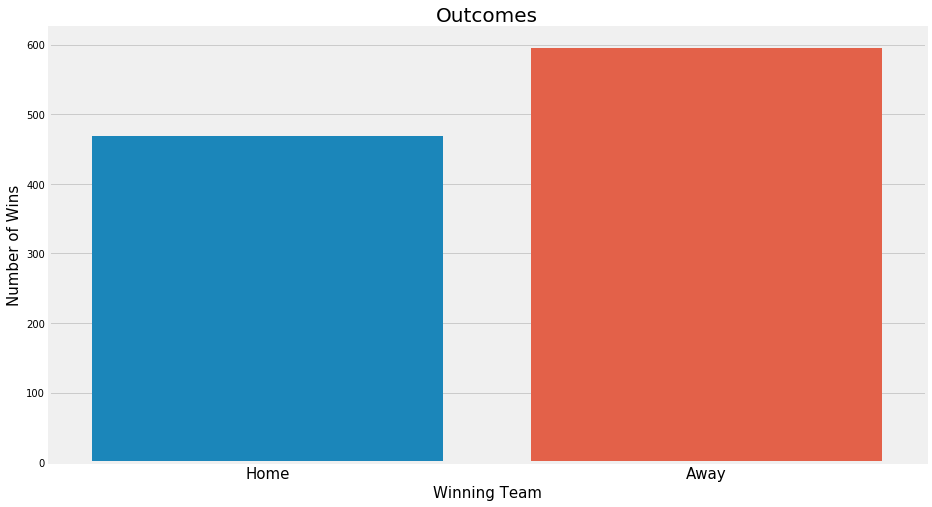

In [6]:
fig, ax = plt.subplots(figsize = (14,8))

sns.countplot(full_matches["win_loc"])

ax.set_title("Outcomes", fontsize=20)

ax.set_xlabel("Winning Team", fontsize=15)
ax.set_ylabel("Number of Wins", fontsize=15)
ax.set_xticklabels(["Home", "Away", "Draw"], fontsize=15)

plt.show()

### Helper Code

Below is the code that will be used to fit our models, record time taken, and gives an accuracy and F1-score

In [7]:
from time import time 
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score, cross_val_predict

def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print ("Trained model in {:.4f} seconds".format(end - start))

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = cross_val_predict(clf, features, target, cv=5)
    
    score = cross_val_score(clf, features, target, cv = 5).mean()
    
    end = time()
    # Print and return results
    print ("Made predictions in {:.4f} seconds.".format(end - start))
    
    return f1_score(target, y_pred), score


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    f1, acc = predict_labels(clf, X_train, y_train)
    print ("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))
    
    f1, acc = predict_labels(clf, X_test, y_test)
    print ("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))
    print("-----------------------------------------------------------------------")

In [8]:
#Function to evaluate predictive models
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
def evaluate_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    score = accuracy_score(y_test, y_pred)
    print ("Accuracy on the test dataset: %s" %score)
    cm = confusion_matrix(y_test, y_pred)
    #print "-------------------------------------------------------------------------------------"
    print ("Confusion matrix")
    print (pd.DataFrame(cm,index=['Benign','Malignant'], columns=['Predicted Benign', 'Predicted Malignant']))
    print ("-------------------------------------------------------------------------------------")
    print ("Classification report")
    print (classification_report(y_test, y_pred, target_names=['Benign','Malignant']))
    print ("-------------------------------------------------------------------------------------")
    
    return score

### Predictions - Naive Model

Lets start with the base model, as you may recall for the basemodel we are only going to be using each team's previous year's ladder score as a predictor.

- Predictors - Previous year's ladder score
- Target - Win Location (Home vs Away)

In [9]:
# Initiates the predictors with columns prevladder scores: X
X = full_matches[["h_prevladder_score", "a_prevladder_score", "season"]]
# Initiates the target as winloc: y
y = full_matches["win_loc"]

In [10]:
# Standardizing
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
Xs = ss.fit_transform(X)
Xs = pd.DataFrame(Xs, columns=X.columns)
Xs.head(3)

,h_prevladder_score,a_prevladder_score,season
0,-0.763082,-1.844120,-1.712426
1,0.213565,0.128324,-1.712426
2,-1.197147,2.100768,-1.712426


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.25, random_state=42)

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB

clf_lr      = LogisticRegression(penalty='l2', solver="liblinear")
clf_svc     = SVC(kernel = 'rbf', probability = True)
clf_xgboost = GradientBoostingClassifier()
clf_forest   = RandomForestClassifier()
clf_tree    = DecisionTreeClassifier()

print("The baseline score for the home team winning is {}\n".format(baseline))
print("-----------------------------------------------------------------------")

train_predict(clf_lr, X_train, y_train, X_test, y_test)
print ('')
train_predict(clf_svc, X_train, y_train, X_test, y_test)
print ('')
train_predict(clf_xgboost, X_train, y_train, X_test, y_test)
print ('')
train_predict(clf_tree, X_train, y_train, X_test, y_test)
print ('')
train_predict(clf_forest, X_train, y_train, X_test, y_test)
print ('')

The baseline score for the home team winning is 55.92%

-----------------------------------------------------------------------
Training a LogisticRegression using a training set size of 798. . .
Trained model in 0.0040 seconds
Made predictions in 0.0836 seconds.
F1 score and accuracy score for training set: 0.7191 , 0.6553.
Made predictions in 0.0455 seconds.
F1 score and accuracy score for test set: 0.7172 , 0.6922.
-----------------------------------------------------------------------

Training a SVC using a training set size of 798. . .
Trained model in 0.2006 seconds
Made predictions in 1.1683 seconds.
F1 score and accuracy score for training set: 0.6981 , 0.6227.
Made predictions in 0.1416 seconds.
F1 score and accuracy score for test set: 0.7000 , 0.6847.
-----------------------------------------------------------------------

Training a GradientBoostingClassifier using a training set size of 798. . .
Trained model in 0.3267 seconds
Made predictions in 1.4956 seconds.
F1 score 

### Results - Naive Model

From just the naive model alone, it appears to do roughly 10% better than the baseline, with Logistic Regression only slightly out-performing the SVC

Classifier         |Accuracy  |F1-Score  |
:--                |:--       |:--       |
Logistic Regression|**67.67%**|  71.52%  |
SVC                |66.17%    |**71.70%**|
Gradient Boosting  |62.78%    |67.55%    |
Decision Tree      |54.89%    |57.35%    |
Random Forest      |56.02%    |63.60%    |


Lets keep adding to the model.


### Predictions - Naive + Teams

In this model, we're going to dummify the teams for both the home and away games and add them to the model. This will add a little bit of general details regarding each team such as any possible rivalries.

We will be using patsy to assist with the dummification of the teams.

In [13]:
import patsy

features = '~ h_prevladder_score + a_prevladder_score + season + premiership + C(home_team) + C(away_team) -1'

In [14]:
# Initiates the predictors: X
X = patsy.dmatrix(features, data=full_matches, return_type='dataframe')
# Initiates the target as winloc: y
y = full_matches["win_loc"]

In [15]:
# Standardizing
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
Xs = ss.fit_transform(X)
Xs = pd.DataFrame(Xs, columns=X.columns)
Xs.head(3)

,C(home_team)[Adelaide],C(home_team)[Carlton],C(home_team)[Collingwood],C(home_team)[Essendon],C(home_team)[Fremantle],C(home_team)[Geelong],C(home_team)[Gold Coast],C(home_team)[Hawthorn],C(home_team)[Melbourne],C(home_team)[North Melbourne],...,C(away_team)[T.Port Adelaide],C(away_team)[T.Richmond],C(away_team)[T.St Kilda],C(away_team)[T.Sydney],C(away_team)[T.West Coast],C(away_team)[T.Western Bulldogs],h_prevladder_score,a_prevladder_score,season,premiership
0,-0.261291,-0.257162,-0.27931,3.888600,-0.255079,-0.27735,-0.212571,-0.265372,-0.248749,-0.248749,...,-0.263338,-0.252982,-0.259233,-0.265372,-0.257162,-0.259233,-0.763082,-1.844120,-1.712426,-0.228961
1,-0.261291,-0.257162,-0.27931,-0.257162,-0.255079,-0.27735,-0.212571,-0.265372,-0.248749,-0.248749,...,-0.263338,-0.252982,-0.259233,-0.265372,-0.257162,-0.259233,0.213565,0.128324,-1.712426,-0.228961
2,-0.261291,-0.257162,-0.27931,-0.257162,3.920361,-0.27735,-0.212571,-0.265372,-0.248749,-0.248749,...,-0.263338,-0.252982,-0.259233,-0.265372,-0.257162,-0.259233,-1.197147,2.100768,-1.712426,-0.228961


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.25, random_state=42)

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB

clf_lr      = LogisticRegression(penalty='l2', solver="liblinear")
clf_svc     = SVC(kernel = 'rbf', probability = True)
clf_xgboost = GradientBoostingClassifier()
clf_forest   = RandomForestClassifier()
clf_tree    = DecisionTreeClassifier()

print("The baseline score for high paying jobs is {}\n".format(baseline))
print("-----------------------------------------------------------------------")

train_predict(clf_lr, X_train, y_train, X_test, y_test)
print ('')
train_predict(clf_svc, X_train, y_train, X_test, y_test)
print ('')
train_predict(clf_xgboost, X_train, y_train, X_test, y_test)
print ('')
train_predict(clf_tree, X_train, y_train, X_test, y_test)
print ('')
train_predict(clf_forest, X_train, y_train, X_test, y_test)
print ('')

The baseline score for high paying jobs is 55.92%

-----------------------------------------------------------------------
Training a LogisticRegression using a training set size of 798. . .
Trained model in 0.0220 seconds
Made predictions in 0.1481 seconds.
F1 score and accuracy score for training set: 0.6979 , 0.6441.
Made predictions in 0.0996 seconds.
F1 score and accuracy score for test set: 0.6690 , 0.6510.
-----------------------------------------------------------------------

Training a SVC using a training set size of 798. . .
Trained model in 0.4113 seconds
Made predictions in 1.9969 seconds.
F1 score and accuracy score for training set: 0.6758 , 0.6127.
Made predictions in 0.4658 seconds.
F1 score and accuracy score for test set: 0.7027 , 0.6694.
-----------------------------------------------------------------------

Training a GradientBoostingClassifier using a training set size of 798. . .
Trained model in 0.2342 seconds
Made predictions in 1.7648 seconds.
F1 score and a

### Results - Naive + Teams

Interesting, besides SVC taking a small hit to both F1-score and accuracy, the others all have increased slightly with Logistic still being ahead by 4%

Classifier         |Accuracy  |F1-Score  |
:--                |:--       |:--       |
Logistic Regression|**71.43%**|**73.97%**|
SVC                |65.04%    |69.10%    |
Gradient Boosting  |67.29%    |70.30%    |
Decision Tree      |57.17%    |59.86%    |
Random Forest      |59.40%    |62.50%    |

It appears that the simplicity of Decision Trees seem to struggle with datasets of higher dimensions. 

### Predictions - Adding Head-to-Head

From here, we're going to try adding the margins for the two teams into the frey. The idea behind Head-to-Head data is further reinforce rivalries between pairs of teams, where for one reason or another a specific team doesnt perform well against another. **Such as 2017 Swans against Hawthorn.**

<img src='img/sadswan.jpg'>

In [18]:
import patsy

features = '~ h_prevladder_score + a_prevladder_score + premiership + margins_prev_match1 + margins_prev_match2 + \
            + margins_prev_match3 + margins_prev_match4 + margins_prev_match5 + C(home_team) + C(away_team) -1'

In [19]:
# Initiates the predictors: X
X = patsy.dmatrix(features, data=full_matches, return_type='dataframe')
# Initiates the target as winloc: y
y = full_matches["win_loc"]

In [20]:
# Standardizing
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
Xs = ss.fit_transform(X)
Xs = pd.DataFrame(Xs, columns=X.columns)

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.25, random_state = 42)

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB

clf_lr      = LogisticRegression(penalty='l2', solver="liblinear")
clf_svc     = SVC(kernel = 'rbf', probability = True)
clf_xgboost = GradientBoostingClassifier()
clf_forest  = RandomForestClassifier()
clf_tree    = DecisionTreeClassifier()

print("The baseline score for high paying jobs is {}\n".format(baseline))
print("-----------------------------------------------------------------------")

train_predict(clf_lr, X_train, y_train, X_test, y_test)
print ('')
train_predict(clf_svc, X_train, y_train, X_test, y_test)
print ('')
train_predict(clf_xgboost, X_train, y_train, X_test, y_test)
print ('')
train_predict(clf_tree, X_train, y_train, X_test, y_test)
print ('')
train_predict(clf_forest, X_train, y_train, X_test, y_test)
print ('')

The baseline score for high paying jobs is 55.92%

-----------------------------------------------------------------------
Training a LogisticRegression using a training set size of 798. . .
Trained model in 0.0160 seconds
Made predictions in 0.1316 seconds.
F1 score and accuracy score for training set: 0.6925 , 0.6415.
Made predictions in 0.0580 seconds.
F1 score and accuracy score for test set: 0.6691 , 0.6549.
-----------------------------------------------------------------------

Training a SVC using a training set size of 798. . .
Trained model in 0.3913 seconds
Made predictions in 1.9374 seconds.
F1 score and accuracy score for training set: 0.6758 , 0.6127.
Made predictions in 0.2512 seconds.
F1 score and accuracy score for test set: 0.7014 , 0.6774.
-----------------------------------------------------------------------

Training a GradientBoostingClassifier using a training set size of 798. . .
Trained model in 0.2797 seconds
Made predictions in 2.1295 seconds.
F1 score and a

### GridSearch - Helper code.

In [23]:
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import KFold

def gridsearch(model, params):
    
    """
    This function simplifies the process of a gridsearch by taking parameters and a model. It searches over a 5 cross\
    validations and prints out the best parameters that it's found as well as the best score

    """
    
    # Initiates a 5-fold gridsearch with specified params
    gs = GridSearchCV(model, params, cv=5)
    
    # Fits the gridsearch to the standardized predictors and target
    gs.fit(Xs,y)
    
    # Displays the best parameters it has found and its corresponding accuracy
    print ("------------------------------------------------------------------------------------")
    print ("Best parameters: {}".format(gs.best_params_))
    print ("Best accuracy score before splitting and training dataset: {:.2f}%\n".format(gs.best_score_*100))
    
    return gs

c:\program files (x86)\python36-32\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
c:\program files (x86)\python36-32\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def evaluate_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    score = accuracy_score(y_test, y_pred)
    print ("Accuracy on the test dataset: {:.2f}%".format(score*100))
    con_matrix = confusion_matrix(y_test, y_pred)
    
    print ("Confusion matrix")
    print (pd.DataFrame(con_matrix,index=['Away Team Wins','Home Team Wins'], columns=['Predicted Away', 'Predicted Home']))
    print ("\n-------------------------------------------------------------------------------------")
    print ("Classification report\n")
    print (classification_report(y_test, y_pred, target_names=['Away Team','Home Team']))
    print ("-------------------------------------------------------------------------------------\n")
    
    print ("Best accuracy score on the testing dataset: {:.2f}%\n".format(score*100))

### Gridsearch - Logistic Regression

**Pros:** 
    - Number of features, which are non-correlated, used in the model don't impact performance

**Cons:** 
    - Requires a large enough sample size

--- 

Since our dataset is based on a boolean result of a home or away team winning, logistic regression would be an 
appropriate method for this dataset.

In [25]:
# Gridsearch parameters for Logistic Regression
lr_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver' : ['liblinear'],
    'penalty' : ['l1', 'l2'],
    'class_weight' : [None, 'balanced'],
}

print("Logistic Regression with Grid Search\n")

# Gridsearchs over the given parameters
gs_lr = gridsearch(clf_lr, lr_params)

# Displays the findings
evaluate_model(gs_lr.best_estimator_) 

Logistic Regression with Grid Search

------------------------------------------------------------------------------------
Best parameters: {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
Best accuracy score before splitting and training dataset: 66.73%

Accuracy on the test dataset: 72.18%
Confusion matrix
                Predicted Away  Predicted Home
Away Team Wins              96              28
Home Team Wins              46              96

-------------------------------------------------------------------------------------
Classification report

             precision    recall  f1-score   support

  Away Team       0.68      0.77      0.72       124
  Home Team       0.77      0.68      0.72       142

avg / total       0.73      0.72      0.72       266

-------------------------------------------------------------------------------------

Best accuracy score on the testing dataset: 72.18%



### Gridsearch - Decision tree

**Pros:**
    - Easy to interpret 
    - Good accuracy for less than a dozen features, which is the case after we have reduced dimension
    - Can handle feature interactions, unlike regression, i.e. collinearity. Although, in our case, we have removed collinearity. 
    
**Cons:**
    - Larger trees with more than a dozen features reduces performance
    - It could be impossible to plan for all contingancies, i.e. features that are not in the dataset. For purposes of this exercise, we assume that the features in our dataset is good enough for prediction. 

In [26]:
# Gridsearch parameters for Decision Trees
tree_params = {
    'max_depth': [None, 1, 2, 3, 4, 5],
    'min_samples_split': [2, 3, 4, 5],
    'class_weight':[None, 'balanced']
}


print ("Decision Tree with Grid Search\n")

# Gridsearchs over the given parameters
gs_tree = gridsearch(clf_tree, tree_params)

# Displays the findings
evaluate_model(gs_tree.best_estimator_)

Decision Tree with Grid Search

------------------------------------------------------------------------------------
Best parameters: {'class_weight': None, 'max_depth': 3, 'min_samples_split': 2}
Best accuracy score before splitting and training dataset: 64.29%

Accuracy on the test dataset: 62.41%
Confusion matrix
                Predicted Away  Predicted Home
Away Team Wins              53              71
Home Team Wins              29             113

-------------------------------------------------------------------------------------
Classification report

             precision    recall  f1-score   support

  Away Team       0.65      0.43      0.51       124
  Home Team       0.61      0.80      0.69       142

avg / total       0.63      0.62      0.61       266

-------------------------------------------------------------------------------------

Best accuracy score on the testing dataset: 62.41%



### Gridsearch - Gradient Descent

**Pros:**
    - Outperforms other models 
    
**Cons:**
    - Difficult to interpret 

In [27]:
# Gridsearch parameters for Decision Trees
xgboost_params = {
    'max_depth': [None, 1, 2, 3, 4, 5],
    'min_samples_split': [2, 3, 4, 5],
}

print ("Decision Tree with Grid Search\n")

# Gridsearchs over the given parameters
gs_xgboost = gridsearch(clf_xgboost, xgboost_params)

# Displays the findings
evaluate_model(gs_xgboost.best_estimator_)

Decision Tree with Grid Search

------------------------------------------------------------------------------------
Best parameters: {'max_depth': 4, 'min_samples_split': 2}
Best accuracy score before splitting and training dataset: 64.76%

Accuracy on the test dataset: 66.17%
Confusion matrix
                Predicted Away  Predicted Home
Away Team Wins              70              54
Home Team Wins              36             106

-------------------------------------------------------------------------------------
Classification report

             precision    recall  f1-score   support

  Away Team       0.66      0.56      0.61       124
  Home Team       0.66      0.75      0.70       142

avg / total       0.66      0.66      0.66       266

-------------------------------------------------------------------------------------

Best accuracy score on the testing dataset: 66.17%



### Gridsearch - Random Forest
**Pros:**
    - Reduces chances of overfitting compared to decision trees because they take the average of several trees, which could lead to improved accuracy compared to decision trees. In this case, given that we have taken care of overfitting with grid search for decision trees, this may not be the case. 

**Cons:**
    - Unlike decision trees, the classifications made by random forests are difficult for humans to interpret
    - Features with categorical variables, which is NOT the case in this dataset, random forests could be more biased towards features with more levels 
    - If the dataset contains groups of correlations between features, which again is NOT the case in this dataset, random forests can favour the groups with a smaller number of features.

In [28]:
# Gridsearch Parameters for Random Forest
forest_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 1, 2, 3, 4, 5],
    'min_samples_split': [2, 3, 4, 5],
    'class_weight':[None, 'balanced']
}


print ("Random Forest with Grid Search\n")

# Gridserachs over the given parameters
gs_forest = gridsearch(clf_forest, forest_params)

# Displays the finding
evaluate_model(gs_forest.best_estimator_)

Random Forest with Grid Search

------------------------------------------------------------------------------------
Best parameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 5}
Best accuracy score before splitting and training dataset: 65.70%

Accuracy on the test dataset: 69.55%
Confusion matrix
                Predicted Away  Predicted Home
Away Team Wins              66              58
Home Team Wins              23             119

-------------------------------------------------------------------------------------
Classification report

             precision    recall  f1-score   support

  Away Team       0.74      0.53      0.62       124
  Home Team       0.67      0.84      0.75       142

avg / total       0.70      0.70      0.69       266

-------------------------------------------------------------------------------------

Best accuracy score on the testing dataset: 69.55%



### Gridsearch -  Support Vector Machine
**Pros:**
    - Accuracy
    - Works well on smaller and cleaner datasets.

**Cons:**
    - Isn’t suited to larger datasets as the training time with SVMs can be high.

### Section 2 Predictions - Findings

---

From the gridsearches done it appears that Logistic Regression marginally outperformed the rest with an accuracy of 67.29%, while this is not absurdly high, it is roughly 10% higher than the baseline of 55.92%.

As mentioned previously, in Section 3, we will use the calculated probabilities from Logistic Regression to calculate odds from each game which will than be compared to the bookies odds.

In the remainder of Section 2 we will look at how our full model fairs when working with data in 5 year blocks. This means that we will train our model on data for 4 years before testing it on the 5th. This is crucial as there have been discussions which have suggested that the playstyle of AFL games have shifted within the last decade.

We will also attempt to pass our dataset through a Neural Network to see how it fairs.

In [29]:
import patsy

features = '~ season + h_prevladder_score + a_prevladder_score + premiership + margins_prev_match1 + margins_prev_match2 + \
            + margins_prev_match3 + margins_prev_match4 + margins_prev_match5 + C(home_team) + C(away_team) -1'

In [30]:
# Initiates the predictors: X
X = patsy.dmatrix(features, data=full_matches, return_type='dataframe')


In [31]:
# Initiates the target as winloc: y
y = full_matches[["season", "win_loc"]]


In [32]:
def five_year_pred(clf, X, y, year):
    
    X_train = X[(X["season"] >= year-5) & (X["season"] <= year-1)].drop(["season"], axis=1)
    X_test  = X[X["season"] == year].drop(["season"], axis=1)
    y_train = y[(y["season"] >= year-5) & (y["season"] <= year-1)]["win_loc"]
    y_test  = y[y["season"] == year]["win_loc"]
    
    train_predict(clf, X_train, y_train, X_test, y_test)

    predictions =  clf.predict_proba(X_test)
    
    year_data = full_matches[full_matches["season"] == year]

    cols_to_keep = ["mid", "win_loc", "season", "home_team", "away_team", "home_odds", "away_odds"]
    year_data = year_data[cols_to_keep].reset_index(drop=True)
    
    probs_df = pd.DataFrame(predictions, columns = ["away_myodds", "home_myodds"])
    probs_df = probs_df[["home_myodds", "away_myodds"]]
    
    probs_df["home_myodds"] = probs_df["home_myodds"].apply(lambda x: 1/x)
    probs_df["away_myodds"] = probs_df["away_myodds"].apply(lambda x: 1/x)

    probs_df = probs_df.round({'away_myodds': 2, 'home_myodds': 2})
    year_odds_comparison = year_data.join(probs_df, how="outer")
    
    

    return year_odds_comparison

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB

clf_lr      = LogisticRegression(penalty='l2', solver="liblinear")
clf_svc     = SVC(kernel = 'rbf', probability = True)
clf_xgboost = GradientBoostingClassifier()
clf_forest  = RandomForestClassifier()
clf_tree    = DecisionTreeClassifier()

In [34]:
predictions = five_year_pred(clf_lr, X, y, year = 2013)

Training a LogisticRegression using a training set size of 582. . .
Trained model in 0.0070 seconds
Made predictions in 0.0761 seconds.
F1 score and accuracy score for training set: 0.7241 , 0.6699.
Made predictions in 0.0430 seconds.
F1 score and accuracy score for test set: 0.6703 , 0.6339.
-----------------------------------------------------------------------



Which leads us to actually using what we've created to attempt some predicting.

Low and Behold **[Section 3 - Tipping](Section 3 - Tipping.ipynb)**